In [1]:
%pylab inline
%run abstractions.py

client = Client("USERNAME", "APIKEY")

Populating the interactive namespace from numpy and matplotlib


# Compile, start and stop using core API

In [2]:
csdl = '''// Score content for SPAM
tags "1e54cbbb3c398956f56e218fffb6ec7f"

// Tag automotive brands
tag "BMW" { fb.parent.content contains_any "BMW" or fb.content contains_any "BMW" }
tag "Honda" { fb.parent.content contains_any "Honda" or fb.content contains_any "Honda" }
tag "Ford" { fb.parent.content contains_any "Ford" or fb.content contains_any "Ford" }

// Tag automotive features
tag.automotive.feature "Style" { fb.content any "paint,matte,white,black,red,blue,silver,bumpers,trim,bumper,door mirror,door mirrors,alloys,alloy wheels,alloy wheel,cool,sexy,beautiful,stunning" OR fb.parent.content any "paint,matte,white,black,red,blue,silver,bumpers,trim,bumper,door mirror,door mirrors,alloys,alloy wheels,alloy wheel,cool,sexy,beautiful,stunning"}
tag.automotive.feature "Practicality" { fb.content any "door,doors,seat,seats,boot,capacity,towing" OR fb.parent.content any "door,doors,seat,seats,boot,capacity,towing"}
tag.automotive.feature "Purchase Price" { fb.content any "cost,price,payments,on the road,quote,deal" OR fb.parent.content any "cost,price,payments,on the road,quote,deal"}
tag.automotive.feature "Environment" { fb.content any "co2,emission,emissions,gasses,hydrogen,gas,fuel cell,hybrid,battery,green,greenest,g/km" OR fb.parent.content any "co2,emission,emissions,gasses,hydrogen,gas,fuel cell,hybrid,battery,green,greenest,g/km"}
tag.automotive.feature "Reliability" { fb.content any "recall,fault,broke down,broken" OR fb.parent.content any "recall,fault,broke down,broken"}
tag.automotive.feature "Safety" { fb.content any "safety,brake light,brakes,abs,fog lights,day running lights,day running light,airbag,seat belt,ebd,epas,child seat,child seats,tyre,tyres,tire,tires" OR fb.parent.content any "safety,brake light,brakes,abs,fog lights,day running lights,day running light,airbag,seat belt,ebd,epas,child seat,child seats,tyre,tyres,tire,tires"}
tag.automotive.feature "Convenience Features" { fb.content any "cruise control,autocruise,auto cruise,trip computer,display,bluetooth,radio,cd,dvd,mp3,speaker,speakers,adjustable,adjust,cushion,remote control,remote controls,air conditioning,keyless,power socket,auto trans,auto transmission" OR fb.parent.content any "cruise control,autocruise,auto cruise,trip computer,display,bluetooth,radio,cd,dvd,mp3,speaker,speakers,adjustable,adjust,cushion,remote control,remote controls,air conditioning,keyless,power socket,auto trans,auto transmission"}
tag.automotive.feature "Performance" { fb.content any "handles,handling,fast,fastest,quick,quickest,wheel drive,engine size,cc,engine power,bhp,top speed,mph,acceleration,performance,turning radius" OR fb.parent.content any "handles,handling,fast,fastest,quick,quickest,wheel drive,engine size,cc,engine power,bhp,top speed,mph,acceleration,performance,turning radius"}
tag.automotive.feature "Running Cost" { fb.content any "costs,mpg,tax,service,serviced,servicing,insurance,mileage,fuel economy,economical,petrol,diesel" OR fb.parent.content any "costs,mpg,tax,service,serviced,servicing,insurance,mileage,fuel economy,economical,petrol,diesel"}
tag.automotive.feature "Mechanical Specification" { fb.content any "turbo,cylinder,engine,4wd,awd,rear wheel drive,torque,exhaust,muffler,cylinder" OR fb.parent.content any "turbo,cylinder,engine,4wd,awd,rear wheel drive,torque,exhaust,muffler,cylinder"}


return {
  (
    fb.parent.content contains_any "BMW, Honda, Ford"
    or
    fb.content contains_any "BMW, Honda, Ford"
  )
  and (fb.topics.category == "Cars" or fb.parent.topics.category == "Cars")
}'''

hash = client.pylon.compile(csdl)['hash']

#client.pylon.start(hash, 'Leaders Debate v1')

print hash

58a4d5a17a7642202ba3d66d504fdeb5


# 1. Get recording object

In [3]:
# Should be client.pylon.recording(hash)
rec = Recording(client, hash)

# 2. Request status of recording

In [4]:
info = rec.get()
print "{0} (volume = {1}, status = {2})".format(info.name, info.volume, info.status)

Automotive Demo v2 (volume = 573985, status = running)


# 3. Make an analysis request

In [5]:
f1 = rec.freq_dist('fb.type',3)

Returned results object exposes structured properties, such as .redacted and .results:

In [6]:
if f1.redacted:
    print 'The analysis results were redacted'
else:    
    print f1.results

{u'comment': {'unique_authors': 36700, 'interactions': 58887}, u'reshare': {'unique_authors': 27200, 'interactions': 31379}, u'like': {'unique_authors': 150200, 'interactions': 185356}}


# 4. Filtering by time period

By default no period is set so API applies default on the platform.

However you can apply a time period as follows:

In [7]:
rec.set_period(info.start,info.end)
rec.set_period(info.start, None)
rec.set_period(None, info.end)

You can also **reset** the period like so:

In [8]:
rec.set_period(None,None)

# 5. Filtering by CSDL

You can apply a filter using CSDL:

In [9]:
rec.set_filter('fb.author.country == "United Kingdom"')

You can **reset** the filter like so:

In [154]:
rec.set_filter(None)

# 6. Language specific features

Python users commonly use Pandas DataFrames to structure and plot data.

This is supported by the library:

In [155]:
f1.to_dataFrame()

,unique_authors,interactions
comment,54900,74098
like,281700,311256
reshare,32500,35730


For example, plotting using Pandas:

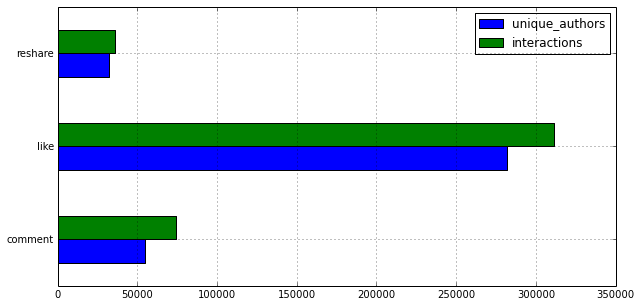

In [156]:
f1.to_dataFrame().plot(kind='barh',figsize=(10,5))

# Example: Time series

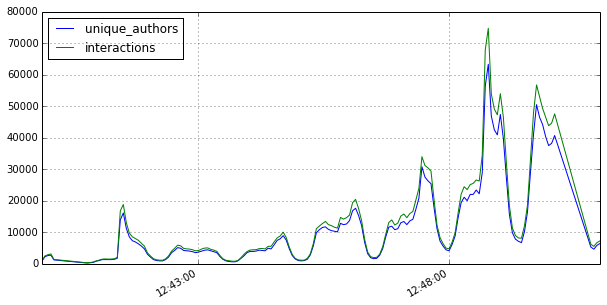

In [167]:
rec.set_period(info.start,info.end)
rec.set_filter(None)
rec.time_series('hour',1).to_dataFrame().plot(figsize=(10,5))

# Example: Age-Gender Pyramid

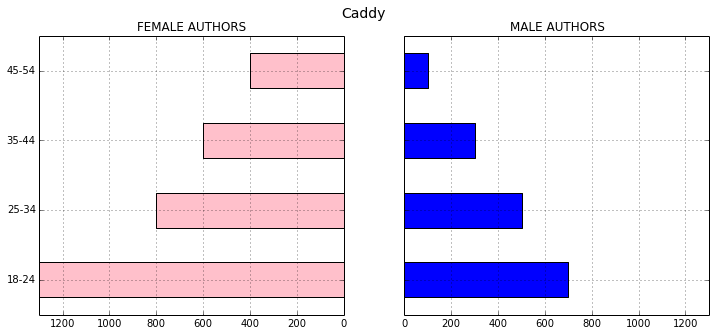

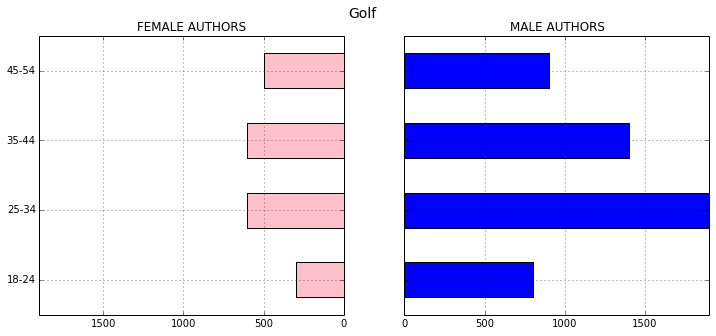

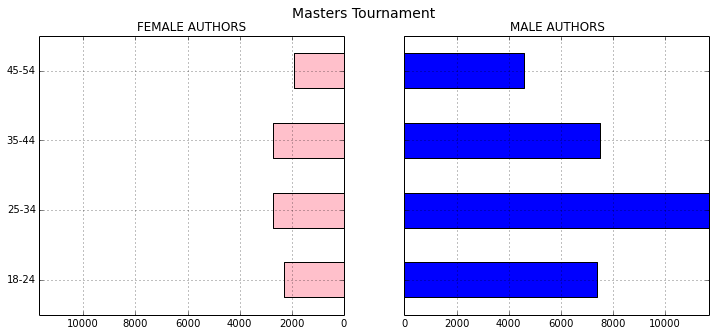

In [168]:
target = 'fb.parent.topics.name'
filter = 'fb.author.country == "United Kingdom"'
genders = "male,female".split(',')

# Set period & filters
rec.set_filter(None)
rec.set_period(info.start,info.end)

# Get top topics
rec.set_filter(filter)
topics = rec.freq_dist(target,3).to_dataFrame()

# For each topic, break down by gender
for i in sorted(topics.index):
    running=list()
    for g in genders:
        csdl= filter + ' AND (%s == "%s" and fb.author.gender == "%s")' % (target,i,g)
        rec.set_filter(csdl)
        running.append(rec.freq_dist('fb.author.age',4).to_dataFrame())

    pyramid=pd.concat(running,keys=genders)
    plot_age_gender_pyramid(pyramid,title=i)